### 1.使用langchain_agent实现pdf和TAVILY工具组合动态调用的实现。


In [14]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from dotenv import load_dotenv, find_dotenv
from langchain import hub
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_community.document_loaders import PDFMinerLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.tools.retriever import create_retriever_tool
import os
    


load_dotenv(find_dotenv())


embedding_model = OpenAIEmbeddings(
    api_key=os.environ['API_KEY'],
    base_url=os.environ['BASE_URL']
)


if not os.path.exists('/Users/peiqi/code/AiPremiumClass/李思佳/week16/Jane'):

    # 加载网页中文本内容，转换为langchain处理的document
    loader = PDFMinerLoader(file_path='/Users/peiqi/code/AiPremiumClass/李思佳/week16/简爱.pdf')

    docs = loader.load()

    # TextSplitter实现加载后的文档的分割
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000, 
        chunk_overlap=200, 
        separators=['\n\n','\n','']
    )
    splited_docs = splitter.split_documents(docs)

    vector_store = FAISS.from_documents(
        documents=splited_docs, 
        embedding=embedding_model
    )

    vector_store.save_local('/Users/peiqi/code/AiPremiumClass/李思佳/week16/Jane')
    print('faiss数据库本地化保存成功')
else:
    vector_store = FAISS.load_local(
        '/Users/peiqi/code/AiPremiumClass/李思佳/week16/Jane',
        embeddings=embedding_model,
        allow_dangerous_deserialization=True                      
        )

    print('加载faiss数据库本地化记录成功')



# 构建检索器
retriever = vector_store.as_retriever(
    search_type="similarity", 
    search_kwargs={"k": 6}
) 

retriever_tool = create_retriever_tool(
    retriever,
    "jane_eyre_novel_summary",
    "Summary of the novel Jane Eyre. Use this tool to answer all questions related to this novel."
)

docs = retriever.invoke("actions and observations")


# 构建LLM
model = ChatOpenAI(model="gpt-3.5-turbo") #支持function call

# 提示词模版
prompt = hub.pull("hwchase17/openai-functions-agent")

# 构建工具
search= TavilySearchResults(max_results=2)


# print(search.invoke("上海今天的天气？"))

# 工具列表
tools = [search, retriever_tool]


agent = create_tool_calling_agent(llm=model, prompt=prompt, tools=tools)

# agent executor
executor = AgentExecutor(agent=agent, tools=tools, verbose=True) #verbose可视化

# 运行agent
msgs = executor.invoke({"input":"北京今天啥天气"})
print(msgs['output'])


加载faiss数据库本地化记录成功


/opt/miniconda3/envs/py312/lib/python3.12/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(




> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'Beijing weather today'}`


[{'title': 'Weather for Beijing, Beijing Municipality, China - Time and Date', 'url': 'https://www.timeanddate.com/weather/china/beijing', 'content': 'timeanddate.com\nFlag for China\n\n# Weather in Beijing, Beijing Municipality, China\n\nHot.\n\nFeels Like: 94 °F  \nForecast: 92 / 76 °F  \nWind: 3 mph ↑ from Southwest\n\n|  |  |\n| --- | --- |\n| Location: | Beijing |\n| Current Time: | Jul 22, 2025 at 7:48:28 pm |\n| Latest Report: | Jul 22, 2025 at 5:00 pm |\n| Visibility: | 14 mi |\n| Pressure: | 29.75 "Hg |\n| Humidity: | 39% |\n| Dew Point: | 64 °F |\n\nLocation of Beijing\nLocation\n\n## Upcoming 5 hours [...] | Amount of Rain | 0.00" | 0.01" | 0.04" | 0.06" | 0.07" | 0.26" | 0.15" |\n| Amount of Snow | 0.00" | 0.00" | 0.00" | 0.00" | 0.00" | 0.00" | 0.00" |\n|  |  |  |  |  |  |  |  |\n| --- | --- | --- | --- | --- | --- | --- | --- |\n| \\ Updated Tuesday,

## rag tool运行截图

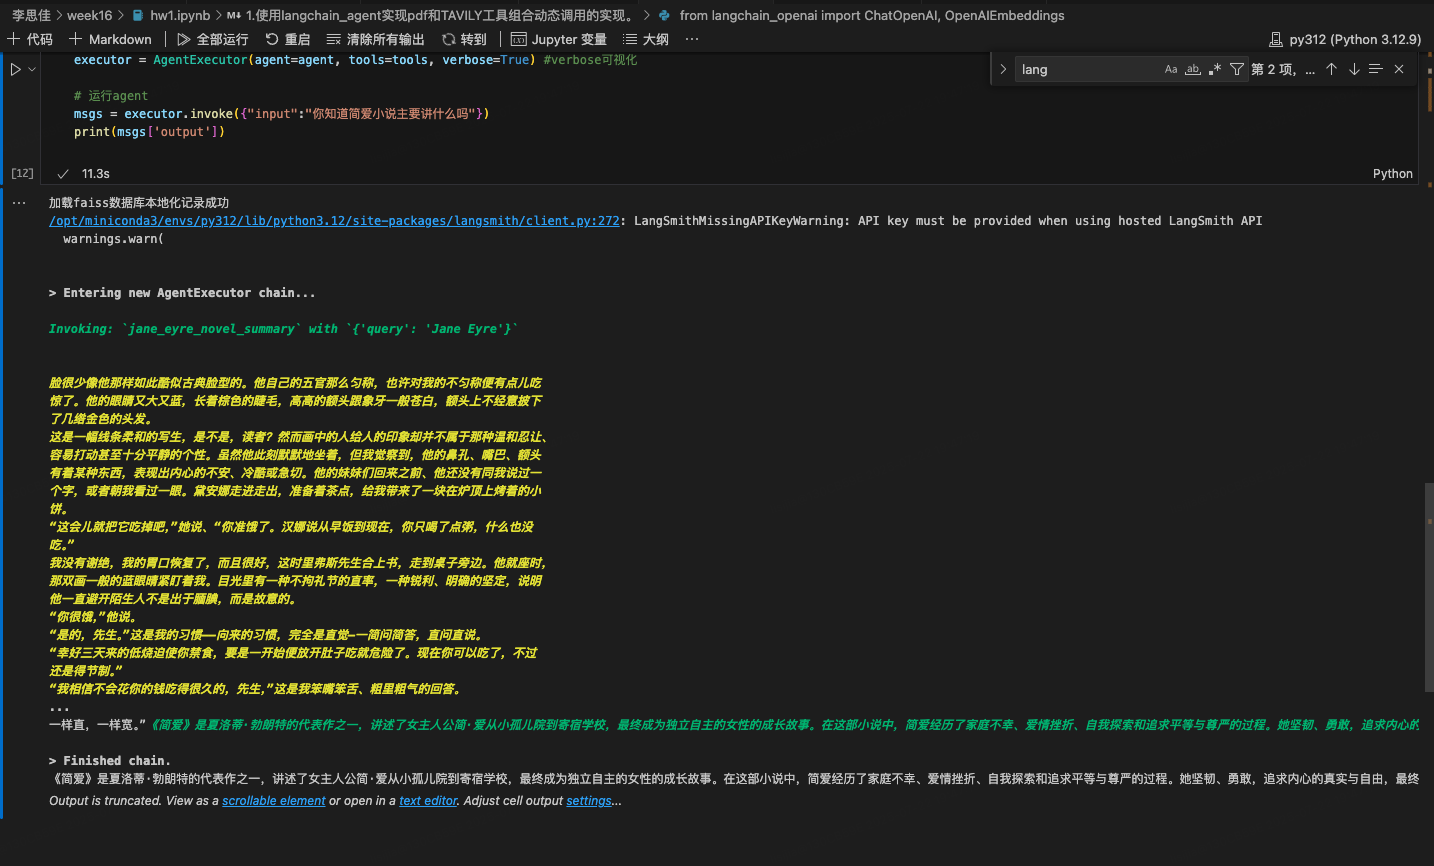

## search tool运行截图

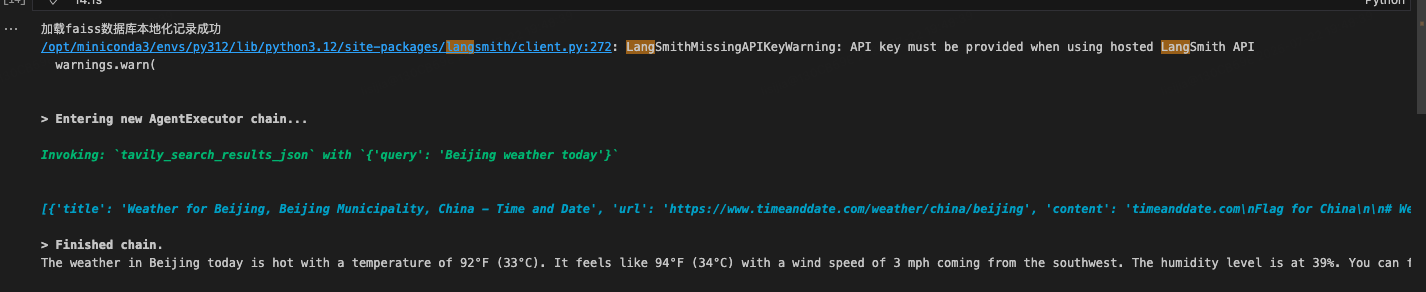